Export the initial data table /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping/output/00_intitial_data.txt


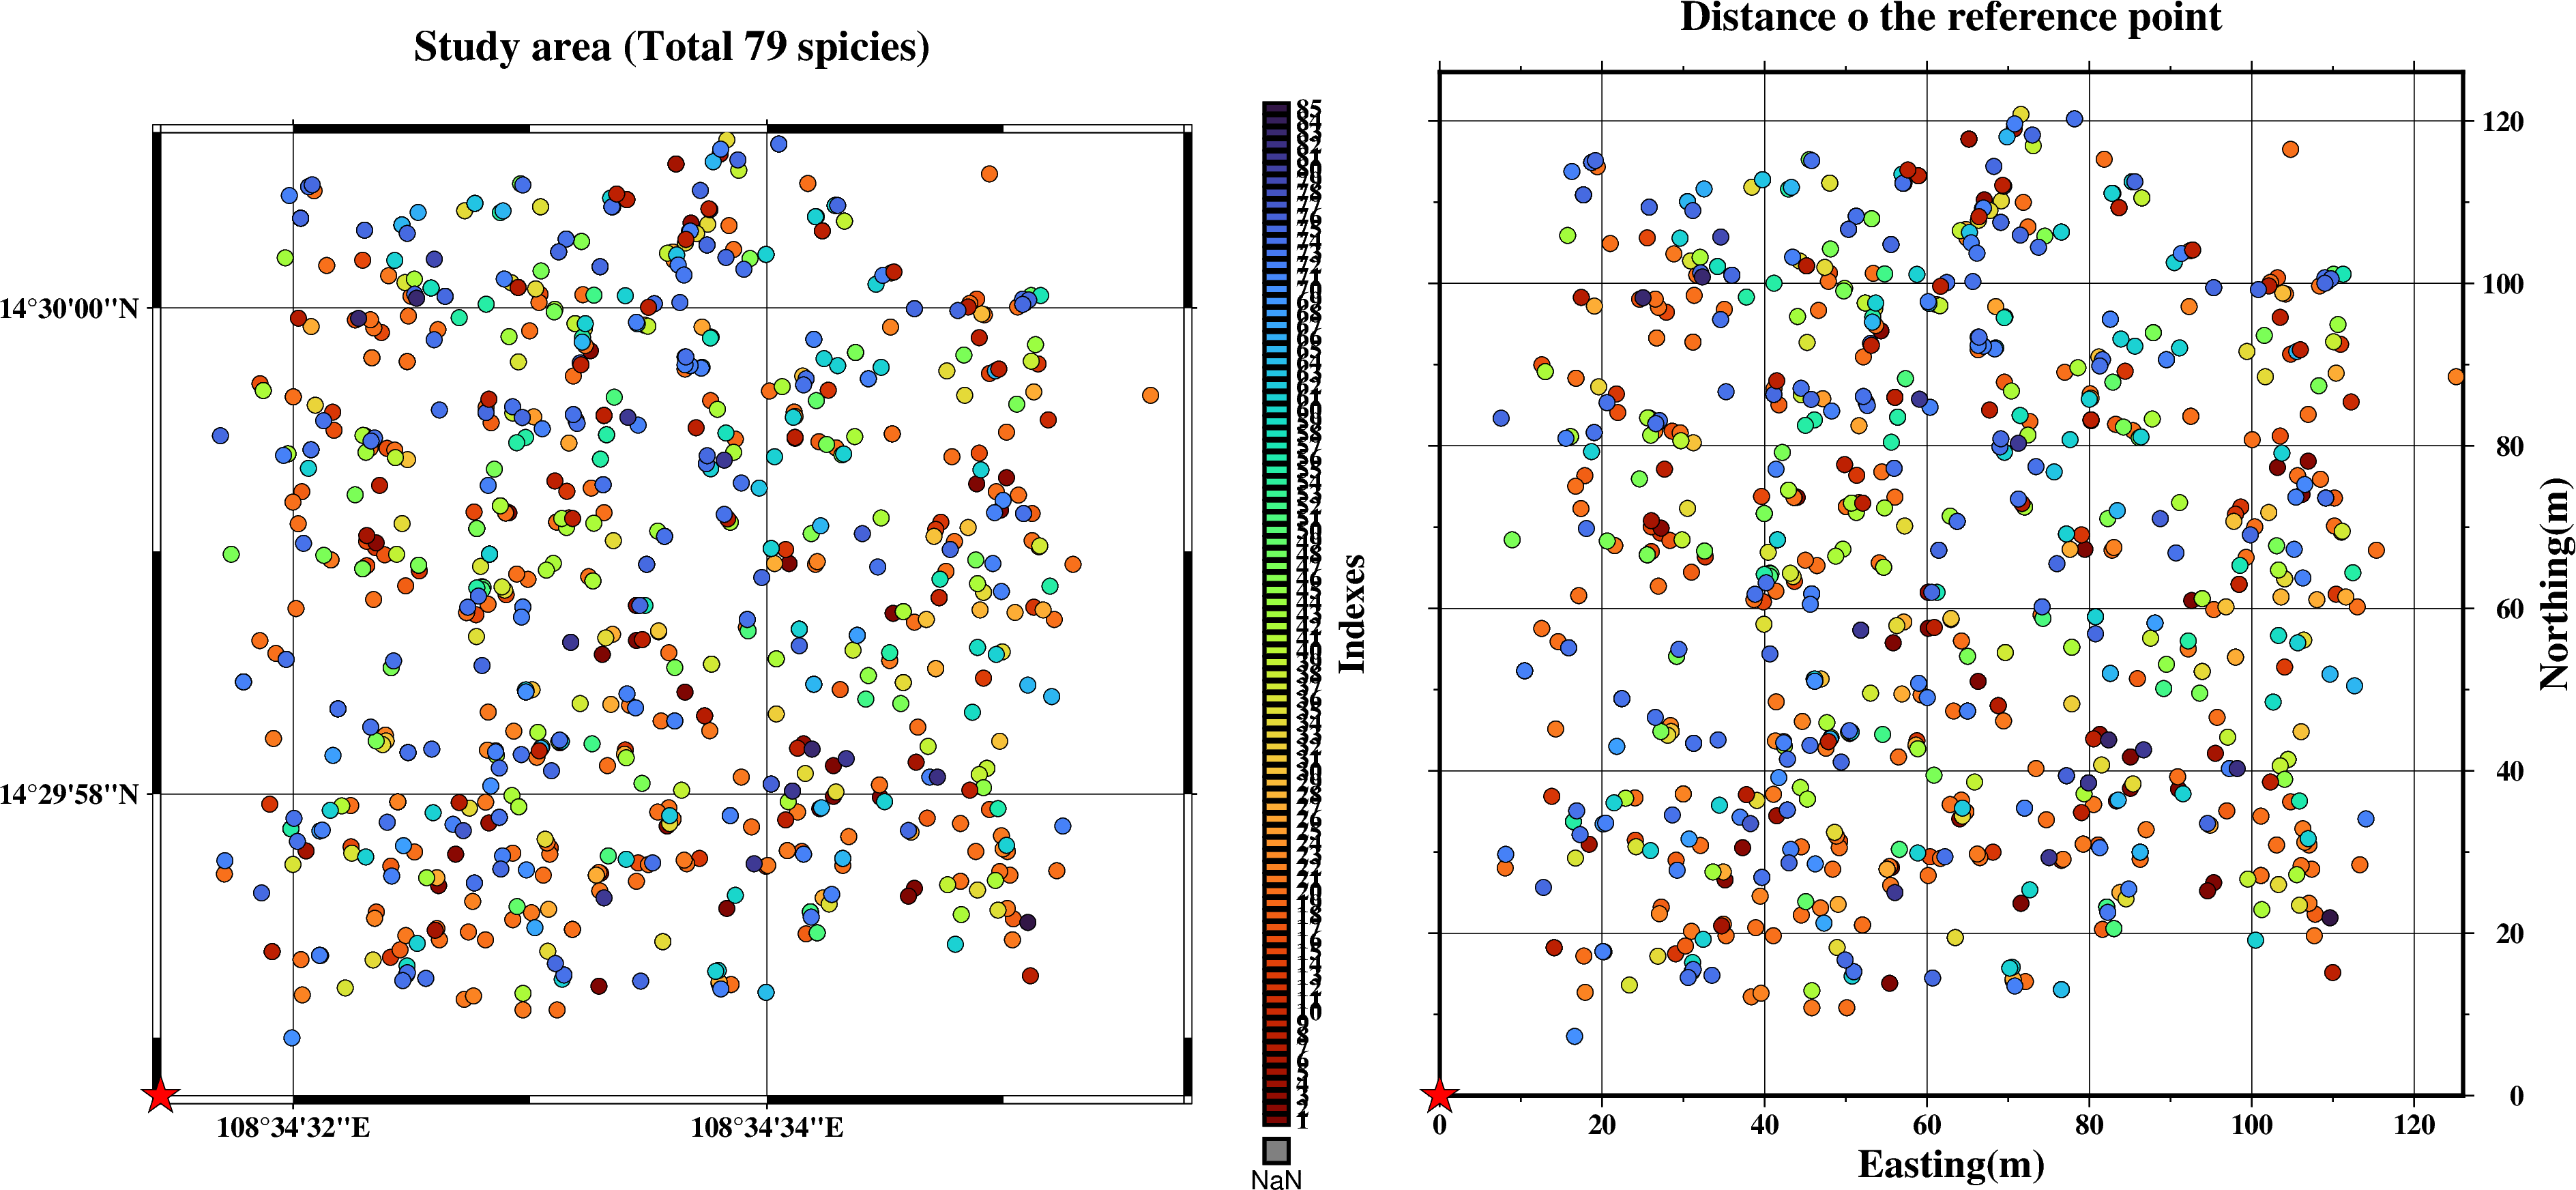

In [8]:
import numpy as np
import pandas as pd
import pygmt
import os
'''
Check the distribution of the spicies inside standard quarant
havinhlong1988@gmail.com - 1st version 20241120
edited: 20250711 - fit with new version of pandas and numpy
'''
# =================================================================================================
def dist2ref(df):
    from pyproj import Geod
    '''
    calculate the distance from the spicy coordinate to reference point
    Input is the data frame, the distance is a new column
    '''
    # Define geodetic system (WGS84)
    geod = Geod(ellps='WGS84')
    # Compute forward and back azimuths and distance
    # Function to compute distance
    def compute_distance(row):
        az12, az21, dist = geod.inv(row['ref_long'], row['ref_lat'],row['Longitude'], row['Latitude'])
        az_rad = np.deg2rad(az12)
        dx = dist * np.sin(az_rad)  # East-west
        dy = dist * np.cos(az_rad)  # North-south
        return pd.Series([dist, dx, dy], index=['distance','d2x', 'd2y'])  # in meters
    # Apply row-wise
    df[['distance','d2x', 'd2y']] = df.apply(compute_distance, axis=1)
    return df
# =================================================================================================
pwd = os.getcwd()
#
outdatdir = os.path.join(pwd,"output")
os.makedirs(outdatdir,exist_ok=True)
#
outfigdir = os.path.join(pwd,"figures")
os.makedirs(outfigdir,exist_ok=True)
# read the data and kip 2 rows due to format error
data = pd.read_csv(os.path.join(pwd,"data","Data_fix.csv"), sep=',',skiprows=None,header=0,)
# # Use str.extract() to split the values into two columns: letter and number
data[['Codechar', 'Codenum']] = data['Code'].str.extract(r'([A-Za-z]+)(\d+)')
# Convert the 'number' column to an integer
data['Codenum'] = data['Codenum'].astype(int)
# remove outliner
data=data[data['Latitude']<=14.5002]
# #
spices_code=data['Code'].unique() # Check how many spices name code in data
spices_name=data['Species'].unique() # Check how many spices latin name in data
# If inconsistencies are found, raise an error and show a report
if len(spices_code) != len(spices_name):
    raise ValueError("Inconsistent species names and spices code: {} - {}".format(len(spices_code),len(spices_name)))
# #
indata = data.copy()
# The study quarrant defined by the 4 points
minx=np.floor(indata['Longitude'].min()*10000)/10000
maxx=np.ceil(indata['Longitude'].max()*10000)/10000
miny=np.floor(indata['Latitude'].min()*10000)/10000
maxy=np.ceil(indata['Latitude'].max()*10000)/10000
area = [minx,maxx,miny,maxy]
# The reference points
ref_point = [minx,miny]
# references long and lat
indata['ref_lat']=ref_point[1]
indata['ref_long']=ref_point[0]
# distance from point to reference points
indata = dist2ref(indata); # apply distance to reference points
indata['sname'] = ['S' + str(i).zfill(4) for i in indata.index]
# Drop the 1st column
indata.drop(indata.columns[0], axis=1, inplace=True)
# replace the indata['sname']
indata.insert(0, 'sname', indata.pop('sname'))
#
print("Export the initial data table {}".format(os.path.join(outdatdir,"00_intitial_data.txt")))
indata.to_csv(os.path.join(outdatdir,"00_intitial_data.txt"),index=False,sep=',',encoding='utf-8')
# # Now plot the distribution by GMT
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="14p,Times-Bold,black",
             FONT_TITLE="15p,Times-Bold,black",
             FONT_ANNOT_PRIMARY="10p,Times-Bold,black",
             FONT_ANNOT_SECONDARY="10p,Times-Bold,black"
            )

# grid = pygmt.datasets.load_earth_relief(resolution="01s", region=area)
# fig.grdimage(grid=grid, projection="X5i/5i", frame="a", cmap="geo")
# fig.colorbar(frame=["a100", "x+lElevation", "y+lm"])
fig.basemap(region=area, projection="M5i", frame=['xafg+l"Longitude(\\240E)"','yafg+l"Latitude(\\240N)"', 
                                                  'WSne+t"Study area (Total {} spicies)"'.format(len(indata['Nomenclature'].unique()))])
#
# pygmt.makecpt(cmap="hawaii",series=[1, 85, 1],)
pygmt.makecpt(cmap="turbo", series=(1,int(indata['Codenum'].max()),1),color_model=f"+c1-{int(indata['Codenum'].max())}",reverse=True, continuous=False)
fig.plot(x=indata['Longitude'], y=indata['Latitude'],style="c0.2c",fill=indata['Codenum'],cmap=True,pen="black")
fig.plot(data=np.array([ref_point]),style="a0.5c",fill="red",pen="black",no_clip=True)
fig.colorbar(
    position="JMR+o1c/0c+w5i/0.3c+n",
    box=False,
    frame=["xa10+lIndexes"],
    scale=1,
)
fig.shift_origin(xshift="1.25w")
maxd = np.maximum(np.ceil(indata['d2x'].max()),np.ceil(indata['d2y'].max()))
#
fig.basemap(region=[0,maxd,0,maxd], projection="X5i/5i", frame=['xafg+l"Easting(m)"','yafg+l"Northing(m)"', 'wSnE+t"Distance o the reference point"'])
fig.plot(x=indata['d2x'], y=indata['d2y'],style="c0.2c",fill=indata['Codenum'],cmap=True,pen="black")
fig.plot(data=np.array([[0,0]]),style="a0.5c",fill="red",pen="black",no_clip=True)

fig.savefig(os.path.join(outfigdir,"00_distribution_long_lat.png"),crop=True, dpi=300, transparent=False)
fig.show()
# Save quarant box
quarant = pd.DataFrame({
    'x': np.array([minx, maxx, maxx, minx]),
    'y': np.array([miny, miny, maxy, maxy])
})
quarant.to_csv(os.path.join(outdatdir,"00_quarant.txt"),index=False,sep=',',encoding='utf-8')
#
indata_backup = indata.copy()

In [9]:
int(indata['Codenum'].max())

85

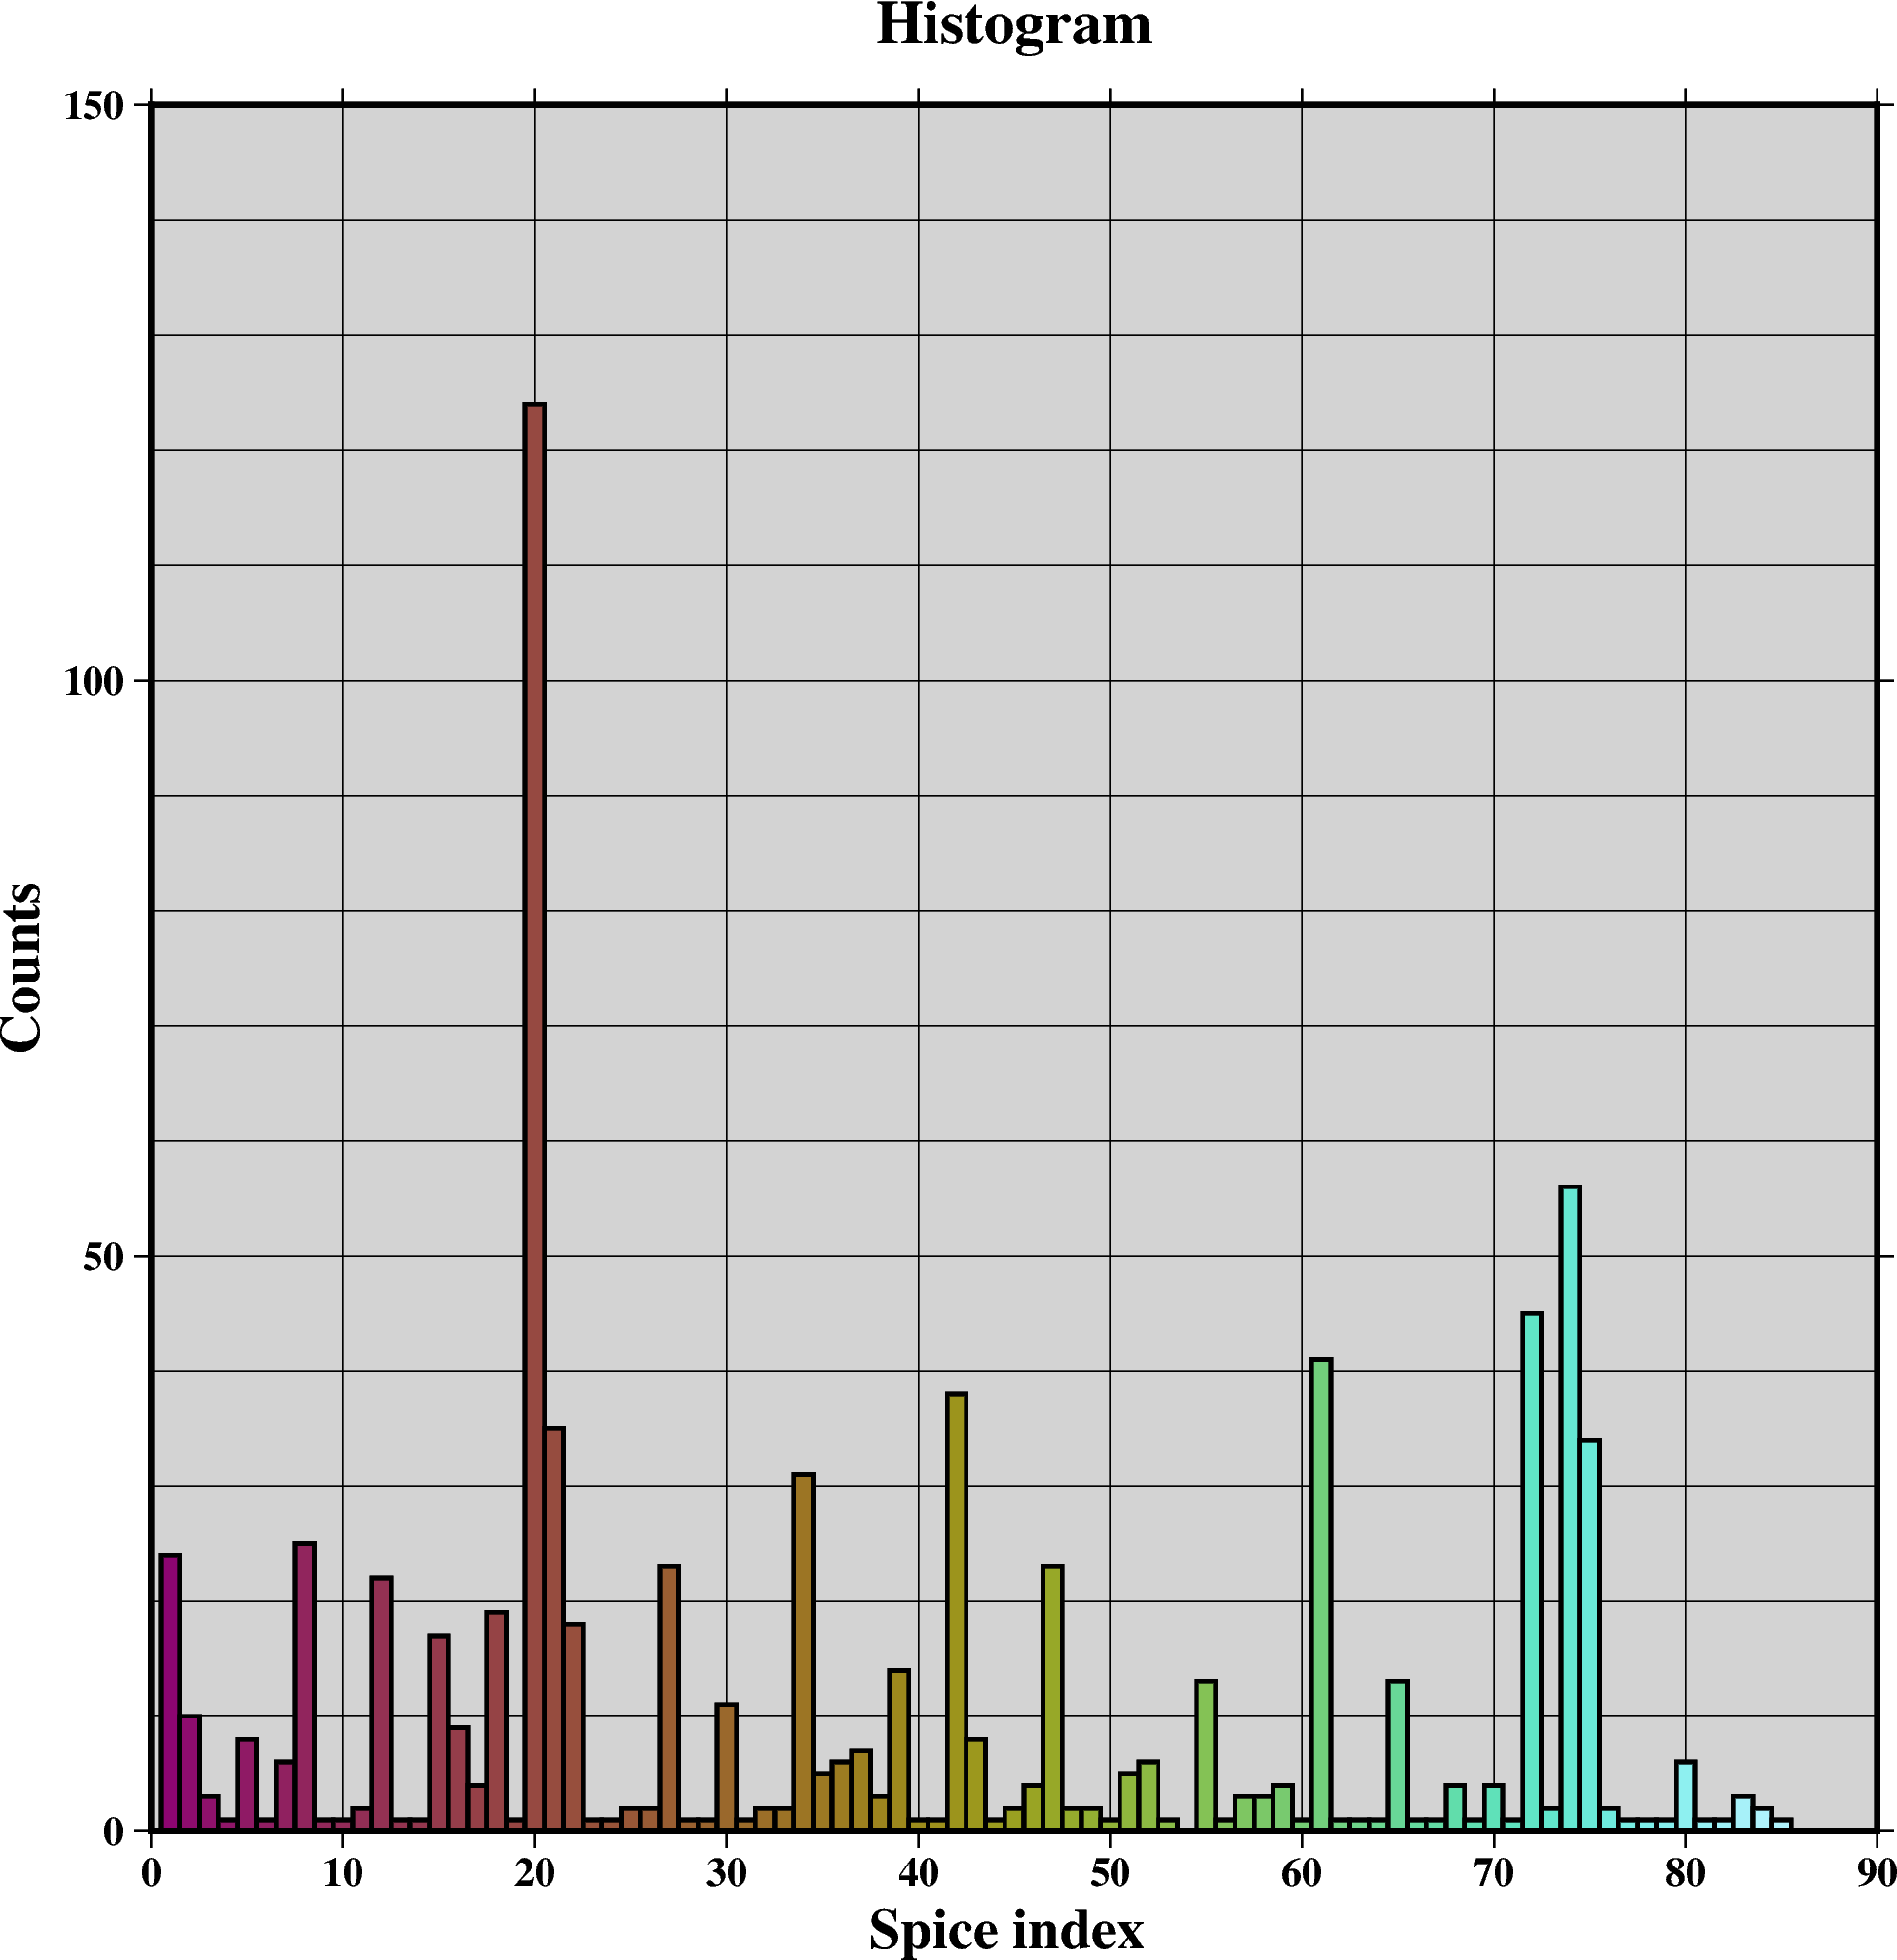

In [59]:
# Plot out the histogram to see Dominant species
fig = pygmt.Figure()
pygmt.makecpt(cmap="hawaii",series=[1, 85, 1],)
fig.histogram(
    data=indata['Codenum'],
    # Define the frame, add a title, and set the background color to
    # "lightgray". Add labels to the x-axis and y-axis
    frame=['WSne+t"Histogram of {} spicies"+glightgray'.format(int(len(indata['Codenum'].unique()))), 'xafg+l"Spice index "', "yafg+lCounts (No of spices)"],
    # Generate evenly spaced bins by increments of 5
    series=1,
    # Use "red3" as color fill for the bars
    cmap=True,
    # Use the pen parameter to draw the outlines with a width of 1 point
    pen="1p",
    # Choose histogram type 0, i.e., counts [Default]
    histtype=0,
    center=True
)
fig.savefig(os.path.join(outfigdir,"01_histogram.png"),crop=True, dpi=300, transparent=True)
fig.show()

In [3]:
'''
Now calculate some interesting things
'''
def area_ha(minlong,maxlong,minlat,maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon
    # Define a list of (longitude, latitude) coordinates that form the boundary of the study area
    coords = [(minlong, minlat), (minlong, maxlat), (maxlong, maxlat), (maxlong, minlat)] 
    # Create a Polygon from the coordinates
    polygon = Polygon(coords)
    # Create a GeoDataFrame with WGS84 CRS (EPSG:3405)
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:6405", geometry=[polygon])
    # Reproject to a UTM projection for area calculation (adjust EPSG based on your location)
    gdf = gdf.to_crs(epsg=3405)  # UTM zone 48N for Vietnam
    # Calculate the area in square meters
    area_sq_meters = gdf.geometry.area[0]
    # Convert square meters to hectares (1 hectare = 10,000 square meters)
    area_hectares = area_sq_meters #/ 10000
    return area_hectares
def area_ha_plain(minlong,maxlong,minlat,maxlat):
    '''
    assumed the area is plain, and 1 degree = 111320 m
    '''
    deg_to_m = 111320
    aream = ((maxlong - minlong ) * deg_to_m) * ((maxlat - minlat ) * deg_to_m) #
    area =  aream/10000 # 1 ha = 10000 meters
    return area
cal_min_x=data['long'].min()
cal_max_x=data['long'].max()
cal_min_y=data['lat'].min()
cal_max_y=data['lat'].max()

S = area_ha_plain(cal_min_x,cal_max_x,cal_min_y,cal_max_y)
# Calculate the spice density based on the area and number of spices in this box
sps=[];
sps_code=[];
sps_num=[];
den0=[];
den=[];
Square_area=[]
for i,sp in enumerate(spices_code):
    sp_now = data[data['code']==sp]; sp_now.reset_index(drop=True,inplace=True)
    sp_den_now = np.float32(len(sp_now))/S;
    # form the array
    sps=np.append(sps,sp)
    sps_code = np.append(sps_code,i)
    sps_num=np.append(sps_num,len(sp_now))
    den0 = np.append(den0,0)
    den = np.append(den,sp_den_now)
    Square_area = np.append(Square_area,S)
# convert to table
df_out = pd.DataFrame({
    'Code': sps,
    'Codenum': sps_code,
    'NoS': sps_num,
    'Den0': den0,
    'Den': den,
    'S(ha)': Square_area
})
# reform number in columns format
df_out['NoS'] = df_out['NoS'].astype(int)
df_out['Codenum'] = df_out['Codenum'].astype(int)
# Format 'FloatColumn' to have 3 decimal places
df_out['Den'] = df_out['Den'].apply(lambda x: np.float32(f"{x:.3f}"))
df_out['S(ha)'] = df_out['S(ha)'].apply(lambda x: np.float32(f"{x:.3f}"))
df_out.reset_index(drop=True,inplace=True)
# Sort the values to see which spices have highest number
df_out_sorted_desc = df_out.sort_values(by=['NoS'], ascending=False)
df_out_sorted_desc.reset_index(drop=True,inplace=True);
df_out_sorted_desc.to_csv('density.txt', sep=' ', index=False)
print("done")

done
